## NN related import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver

## Data related

* Define ChunkSampler to split original train data into train part and validation part
* Define loaders

In [12]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Basic configuration

In [13]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
def show_training(solver):
    plt.subplot(2, 1, 1)
    plt.plot(example_solver.loss_history, 'o')
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.plot(example_solver.train_acc_history, '-o')
    plt.plot(example_solver.val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

def compare_two_training(solver_labels, solver1, solver2):
    plt.subplot(3, 1, 1)
    plt.title('Training loss')
    plt.xlabel('Iteration')

    plt.subplot(3, 1, 2)
    plt.title('Training accuracy')
    plt.xlabel('Epoch')

    plt.subplot(3, 1, 3)
    plt.title('Validation accuracy')
    plt.xlabel('Epoch')

    plt.subplot(3, 1, 1)
    plt.plot(solver1.loss_history, 'o', label=solver_labels[0])
    plt.plot(solver2.loss_history, 'o', label=solver_labels[1])

    plt.subplot(3, 1, 2)
    plt.plot(solver1.train_acc_history, '-o', label=solver_labels[0])
    plt.plot(solver2.train_acc_history, '-o', label=solver_labels[1])

    plt.subplot(3, 1, 3)
    plt.plot(solver1.val_acc_history, '-o', label=solver_labels[0])
    plt.plot(solver2.val_acc_history, '-o', label=solver_labels[1])
  
    for i in [1, 2, 3]:
      plt.subplot(3, 1, i)
      plt.legend(loc='upper center', ncol=4)
    
    plt.gcf().set_size_inches(15, 15)
    plt.show()
    
def compare_training(solvers_with_labels):
    plt.subplot(3, 1, 1)
    for label in solvers_with_labels:
        plt.plot(solvers_with_labels[label].loss_history, 'o', label=label)
    plt.title('Train loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend(ncol=2, loc='lower right')
  
    plt.subplot(3, 1, 2)
    for label in solvers_with_labels:
        plt.plot(solvers_with_labels[label].train_acc_history, '-o', label=label)
    plt.title('Train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(ncol=2, loc='lower right')
    
    plt.subplot(3, 1, 3)
    for label in solvers_with_labels:
        plt.plot(solvers_with_labels[label].val_acc_history, '-o', label=label)
    plt.title('Val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(ncol=2, loc='lower right')
    
    plt.gcf().set_size_inches(15, 15)
    plt.show()

def plot_mean_std_hist(parameters):
    ws = list(parameters)

    ws_means = [torch.mean(w.data) for w in ws]
    ws_stds = [torch.std(w.data) for w in ws]
    
    for i in range(len(ws)):
        print('weight index: ', i)
        print('with size ', ws[i].data.size())
        print('with mean: %f, std: %f' % (ws_means[i], ws_stds[i]))
        
    plt.figure()
    plt.subplot(121)
    plt.plot(range(len(ws_means)), ws_means, 'ob-')
    plt.title('weights means')
    plt.subplot(122)
    plt.plot(range(len(ws_stds)), ws_stds, 'or-')
    plt.title('weights stds')

    plt.figure()
    for i in range(len(ws)):
        plt.subplot(len(ws), 1, i+1)
        #plt.subplot(1, len(ws), i+1)
        plt.hist(ws[i].data.cpu().numpy().ravel(), 30)
        plt.title('weights %d hist' % i)
    
    plt.show()
    


## First example model

In [5]:
# model
example_model = models.ExampleNet().type(dtype)

# loss function
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

# optimizer
example_optimizer = optim.Adam(example_model.parameters(), lr=1e-3)

### model sanity check

#### output size

In [6]:
x = torch.randn(64, 3, 32, 32).type(dtype)
x_var = Variable(x, requires_grad=False)
ans = example_model(x_var)

np.array_equal(np.array(ans.size()), np.array([64, 10]))

True

In [31]:
%%timeit
torch.cuda.synchronize()
ans = example_model.type(dtype)(x_var)
torch.cuda.synchronize()

942 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%%timeit
ans = example_model.type(torch.FloatTensor)(x_var.cpu())

18.7 ms ± 534 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### train example model

In [ ]:
torch.cuda.random.manual_seed(12345)
#example_model.apply(reset)

# model
example_model = models.ExampleNet().type(dtype)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_optimizer = optim.Adam(example_model.parameters(), lr=1e-3)
example_optimizer = optim.SGD(example_model.parameters(), lr=3e-3, momentum=0.9, weight_decay=1e-5)
#example_optimizer = optim.RMSprop(example_model.parameters(), lr=5e-5, weight_decay=1e-2)

example_exp_lr_scheduler = None
#example_exp_lr_scheduler = lr_scheduler.StepLR(example_optimizer, step_size=3, gamma=0.5)

example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=10, verbose=True)

example_solver.train()

t = 0, loss = 2.3972
t = 100, loss = 1.6104
t = 200, loss = 1.1841
t = 300, loss = 1.4032
t = 400, loss = 1.2136
t = 500, loss = 1.5546
t = 600, loss = 1.3286
t = 700, loss = 1.2518
(Epoch 0 / 10) train acc: 0.491211; val acc: 0.472000
t = 0, loss = 1.1494
t = 100, loss = 1.2858
t = 200, loss = 0.8499
t = 300, loss = 1.1195
t = 400, loss = 1.1182
t = 500, loss = 1.4108
t = 600, loss = 1.1012
t = 700, loss = 1.2100
(Epoch 1 / 10) train acc: 0.586914; val acc: 0.567000
t = 0, loss = 1.0409
t = 100, loss = 1.0452
t = 200, loss = 0.7598
t = 300, loss = 1.0203
t = 400, loss = 1.0511
t = 500, loss = 1.2524
t = 600, loss = 1.0501
t = 700, loss = 1.1536
(Epoch 2 / 10) train acc: 0.589844; val acc: 0.583000
t = 0, loss = 0.9287
t = 100, loss = 0.9031
t = 200, loss = 0.7169
t = 300, loss = 0.9503
t = 400, loss = 1.0301
t = 500, loss = 1.1636


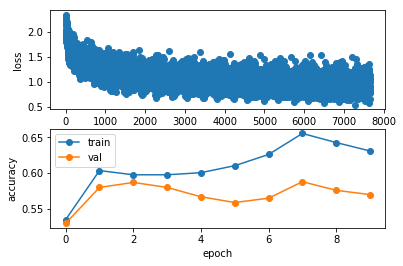

In [25]:
show_training(example_solver)

weight index:  0
with size  torch.Size([32, 3, 7, 7])
with mean: -0.011754, std: 0.120652
weight index:  1
with size  torch.Size([32])
with mean: 0.026432, std: 0.148125
weight index:  2
with size  torch.Size([32])
with mean: 0.356702, std: 0.186884
weight index:  3
with size  torch.Size([32])
with mean: -0.048257, std: 0.070690
weight index:  4
with size  torch.Size([1024, 5408])
with mean: 0.000004, std: 0.008680
weight index:  5
with size  torch.Size([1024])
with mean: -0.000248, std: 0.015038
weight index:  6
with size  torch.Size([10, 1024])
with mean: 0.000012, std: 0.024594
weight index:  7
with size  torch.Size([10])
with mean: -0.001301, std: 0.314113


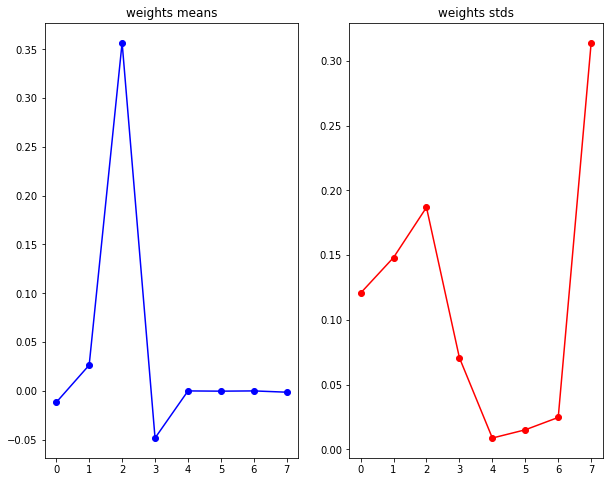

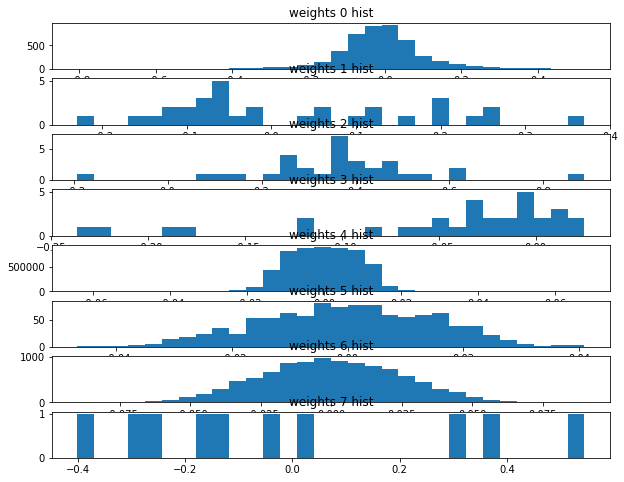

In [51]:
plot_mean_std_hist(example_model.parameters())

In [7]:
# Cross validation
import numpy as np

train_stats = {}

# model
example_model = models.ExampleNet().type(dtype)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 100
for count in range(max_count):
    lr = 10**np.random.uniform(-5, -3)
    reg = 10**np.random.uniform(-6, -1)
    
    # for saving memory?
    example_model.apply(reset)
    example_optimizer = optim.SGD(example_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    example_exp_lr_scheduler = None
    
    example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=5, verbose=False)
    example_solver.train()
    train_stats[(lr, reg)] = (example_solver.train_acc_history, example_solver.val_acc_history, example_solver.loss_history)
    print('lr: %f, reg: %f, train accuracy: %f, val accuracy: %f, final loss: %f' % (
        lr, reg, example_solver.train_acc_history[-1], example_solver.val_acc_history[-1], example_solver.loss_history[-1]))
    
   

lr: 0.000025, reg: 0.000286, train accuracy: 0.423828, val accuracy: 0.435000, final loss: 1.783290
lr: 0.001015, reg: 0.000003, train accuracy: 0.627930, val accuracy: 0.590000, final loss: 0.785046
lr: 0.000052, reg: 0.000008, train accuracy: 0.487305, val accuracy: 0.484000, final loss: 1.637079
lr: 0.000120, reg: 0.000837, train accuracy: 0.562500, val accuracy: 0.568000, final loss: 1.390972
lr: 0.000662, reg: 0.000002, train accuracy: 0.647461, val accuracy: 0.598000, final loss: 0.800383
lr: 0.000947, reg: 0.059557, train accuracy: 0.507812, val accuracy: 0.496000, final loss: 1.257397
lr: 0.000037, reg: 0.000194, train accuracy: 0.449219, val accuracy: 0.439000, final loss: 1.659279
lr: 0.000040, reg: 0.004982, train accuracy: 0.468750, val accuracy: 0.475000, final loss: 1.704209
lr: 0.002719, reg: 0.002077, train accuracy: 0.556641, val accuracy: 0.515000, final loss: 0.937176
lr: 0.000037, reg: 0.000003, train accuracy: 0.466797, val accuracy: 0.468000, final loss: 1.646924


KeyboardInterrupt: 

## Different models and comparision

In [ ]:
torch.cuda.random.manual_seed(12345)
#example_dropout_model.apply(reset)

# model
example_dropout_model = models.ExampleDropoutNet().type(dtype)
example_dropout_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_dropout_optimizer = optim.Adam(example_dropout_model.parameters(), lr=1e-3)
example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=1e-3, momentum=0.9)
example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=5e-4, momentum=0.9, weight_decay=2e-4)
#example_dropout_optimizer = optim.RMSprop(example_dropout_model.parameters(), lr=1e-4)

#example_dropout_exp_lr_scheduler = None
example_dropout_exp_lr_scheduler = lr_scheduler.StepLR(example_dropout_optimizer, step_size=5, gamma=0.7)

example_dropout_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_dropout_model,
                                     loss_fn=example_dropout_loss_fn,
                                     optimizer=example_dropout_optimizer,
                                     scheduler=example_dropout_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=20, verbose=True)

example_dropout_solver.train()

t = 0, loss = 2.3113
t = 100, loss = 2.0370
t = 200, loss = 1.7512
t = 300, loss = 1.8705
t = 400, loss = 1.8021
t = 500, loss = 1.7813
t = 600, loss = 1.7614
t = 700, loss = 1.5054
(Epoch 0 / 20) train acc: 0.462891; val acc: 0.458000
t = 0, loss = 1.5220
t = 100, loss = 1.5954
t = 200, loss = 1.3183
t = 300, loss = 1.5475
t = 400, loss = 1.4190
t = 500, loss = 1.4770
t = 600, loss = 1.5073
t = 700, loss = 1.3810
(Epoch 1 / 20) train acc: 0.504883; val acc: 0.502000
t = 0, loss = 1.3587
t = 100, loss = 1.4318
t = 200, loss = 1.1550
t = 300, loss = 1.3484
t = 400, loss = 1.1593
t = 500, loss = 1.4734
t = 600, loss = 1.3257
t = 700, loss = 1.3006
(Epoch 2 / 20) train acc: 0.598633; val acc: 0.555000
t = 0, loss = 1.1981
t = 100, loss = 1.3434
t = 200, loss = 1.0745
t = 300, loss = 1.1750
t = 400, loss = 1.0689
t = 500, loss = 1.2769
t = 600, loss = 1.2348
t = 700, loss = 1.2871
(Epoch 3 / 20) train acc: 0.629883; val acc: 0.590000
t = 0, loss = 1.0687
t = 100, loss = 1.2299
t = 200, los

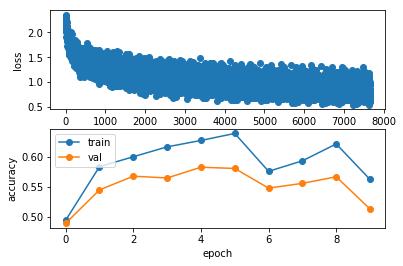

test acc:  0.7036


In [71]:
show_training(example_dropout_solver)

In [15]:
# Cross validation
import numpy as np

train_stats = {}

# model
example_dropout_model = models.ExampleDropoutNet().type(dtype)
example_dropout_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 100
for count in range(max_count):
    lr = 10**np.random.uniform(-5, -3)
    reg = 10**np.random.uniform(-5, 5)
    
    # for saving memory?
    example_dropout_model.apply(reset)
    example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    example_dropout_exp_lr_scheduler = None
    
    example_dropout_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_dropout_model,
                                     loss_fn=example_dropout_loss_fn,
                                     optimizer=example_dropout_optimizer,
                                     scheduler=example_dropout_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=5, verbose=False)
    example_dropout_solver.train()
    train_stats[(lr, reg)] = (example_dropout_solver.train_acc_history,
                              example_dropout_solver.val_acc_history, 
                              example_dropout_solver.loss_history)
    print('lr: %f, reg: %f, train accuracy: %f, val accuracy: %f, final loss: %f' % (
        lr, reg, example_dropout_solver.train_acc_history[-1],
        example_dropout_solver.val_acc_history[-1],
        example_dropout_solver.loss_history[-1]))
    

lr: 0.000022, reg: 33.366910, train accuracy: 0.083984, val accuracy: 0.098000, final loss: 2.302578
lr: 0.000591, reg: 0.000068, train accuracy: 0.526367, val accuracy: 0.496000, final loss: 1.003915
lr: 0.000076, reg: 0.000021, train accuracy: 0.477539, val accuracy: 0.473000, final loss: 1.752884
lr: 0.000070, reg: 0.008701, train accuracy: 0.467773, val accuracy: 0.454000, final loss: 1.766010
lr: 0.000139, reg: 0.001441, train accuracy: 0.528320, val accuracy: 0.523000, final loss: 1.515644
lr: 0.000784, reg: 0.109418, train accuracy: 0.442383, val accuracy: 0.441000, final loss: 1.503489
lr: 0.000058, reg: 3072.856106, train accuracy: 0.091797, val accuracy: 0.112000, final loss: 2.302586
lr: 0.000026, reg: 1.764403, train accuracy: 0.293945, val accuracy: 0.304000, final loss: 2.298055
lr: 0.000030, reg: 0.028021, train accuracy: 0.398438, val accuracy: 0.399000, final loss: 1.911309
lr: 0.000014, reg: 443.349295, train accuracy: 0.098633, val accuracy: 0.113000, final loss: 2.3

KeyboardInterrupt: 

### Compare

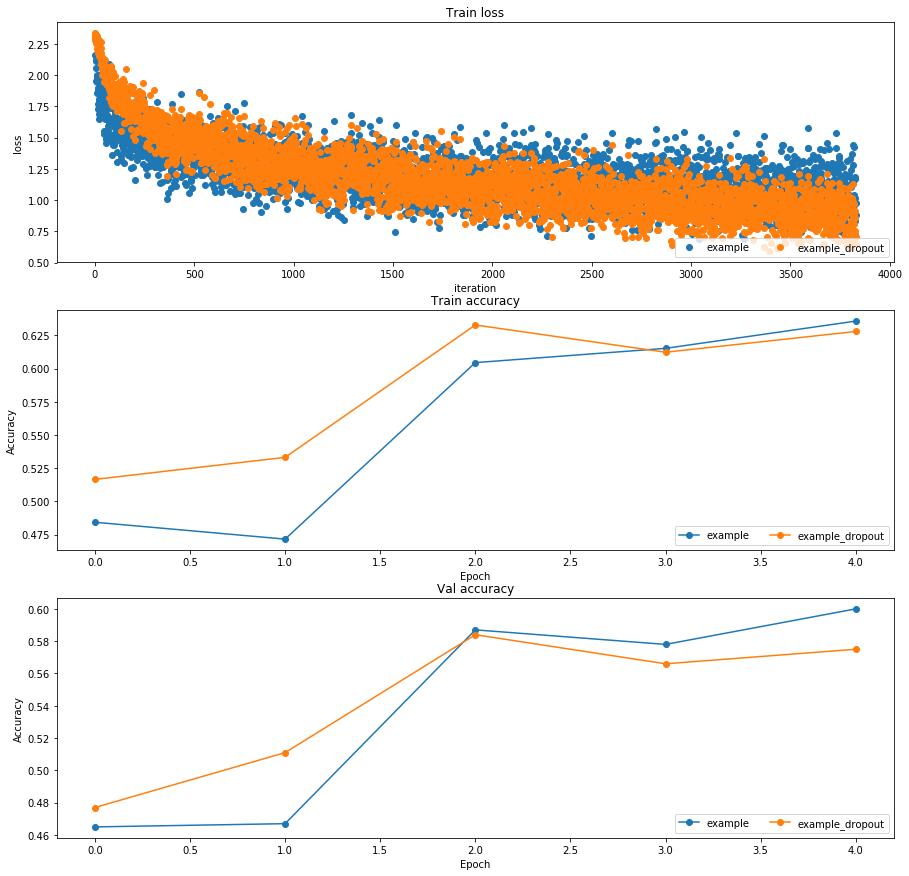

In [54]:
#compare_two_training(['example', 'example_dropout'], example_solver, example_dropout_solver)
compare_training({'example': example_solver, 'example_dropout': example_dropout_solver})

In [55]:
torch.cuda.random.manual_seed(12345)

# model
small_filter_model = models.SmallFilterNet().type(dtype)
small_filter_loss_fn = nn.CrossEntropyLoss().type(dtype)
#small_filter_optimizer = optim.SGD(small_filter_model.parameters(), lr=1e-3, momentum=0.9)

small_filter_optimizer = optim.Adam(small_filter_model.parameters(), lr=1e-4)
#small_filter_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=5, gamma=0.1)

small_filter_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=small_filter_model,
                                     loss_fn=small_filter_loss_fn,
                                     optimizer=small_filter_optimizer,
                                     scheduler=None,
                                     dtype=dtype,
                                     num_epochs=5, verbose=True)

small_filter_solver.train()

t = 0, loss = 2.2923
t = 100, loss = 1.4914
t = 200, loss = 1.1813
t = 300, loss = 1.2364
t = 400, loss = 1.1639
t = 500, loss = 1.4779
t = 600, loss = 1.2303
t = 700, loss = 1.2137
(Epoch 0 / 5) train acc: 0.632812; val acc: 0.620000
t = 0, loss = 0.9352
t = 100, loss = 0.9462
t = 200, loss = 0.8433
t = 300, loss = 0.9508
t = 400, loss = 0.9136
t = 500, loss = 1.2374
t = 600, loss = 1.0051
t = 700, loss = 1.0290
(Epoch 1 / 5) train acc: 0.687500; val acc: 0.639000
t = 0, loss = 0.7697
t = 100, loss = 0.8152
t = 200, loss = 0.7577
t = 300, loss = 0.8020
t = 400, loss = 0.7857
t = 500, loss = 1.1135
t = 600, loss = 0.8702
t = 700, loss = 0.9359
(Epoch 2 / 5) train acc: 0.719727; val acc: 0.653000
t = 0, loss = 0.6737
t = 100, loss = 0.7586
t = 200, loss = 0.7239
t = 300, loss = 0.7153
t = 400, loss = 0.6944
t = 500, loss = 1.0146
t = 600, loss = 0.7816
t = 700, loss = 0.8611
(Epoch 3 / 5) train acc: 0.738281; val acc: 0.665000
t = 0, loss = 0.6179
t = 100, loss = 0.7181
t = 200, loss = 

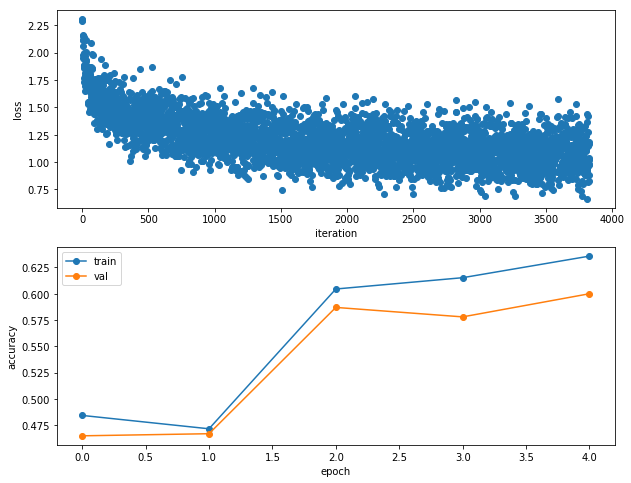

In [56]:
show_training(small_filter_solver)

/home/aaron/yalong/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


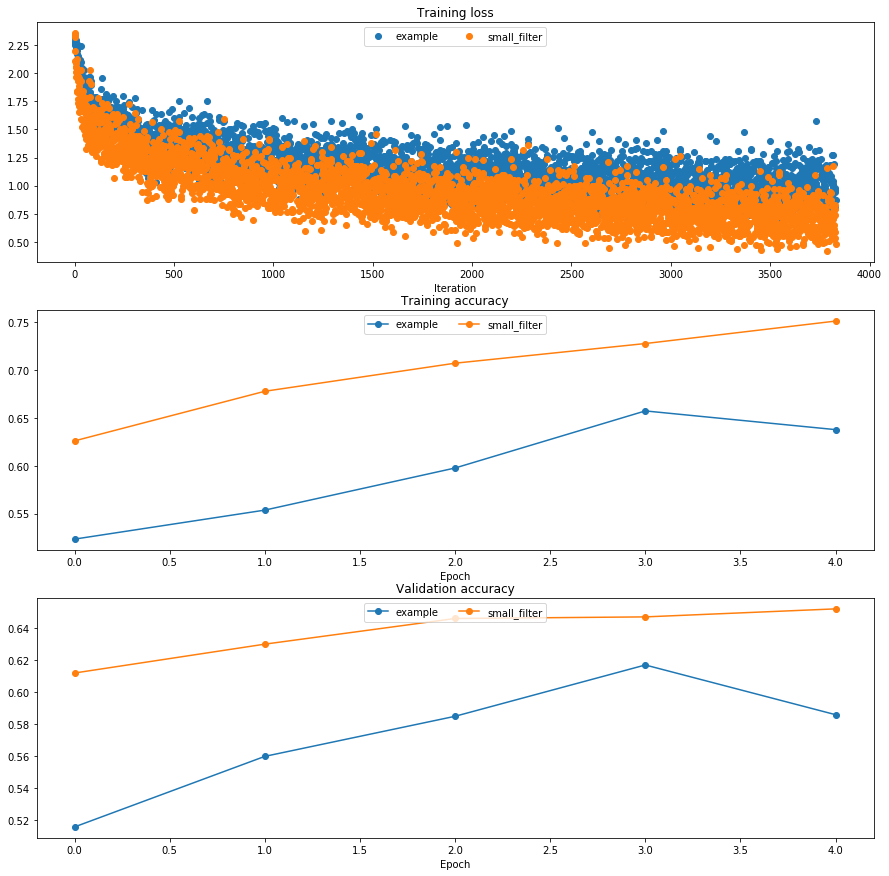

In [123]:
compare_two_training(['example', 'small_filter'], example_solver, small_filter_solver)

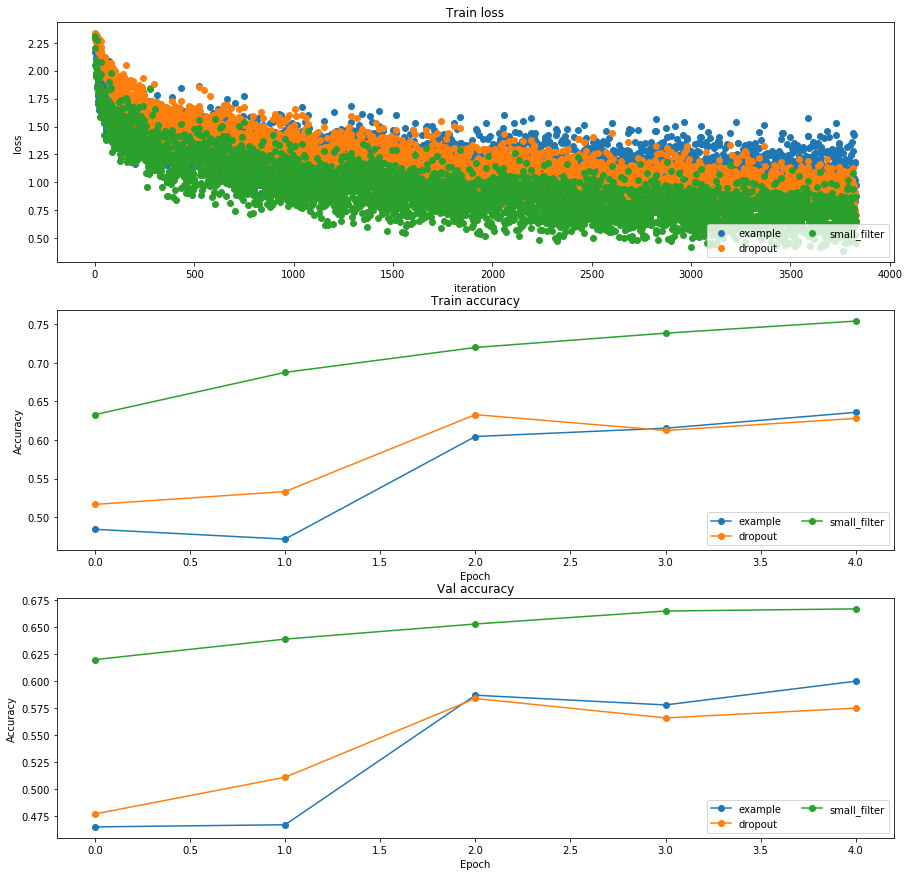

In [57]:
compare_training({'example': example_solver,
                  'dropout': example_dropout_solver,
                  'small_filter': small_filter_solver})

SmallFilterNet(
  (features): Sequential(
    (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(
    )
    (1): Linear(in_features=4096, out_features=1024)
    (2): Linear(in_features=1024, out_features=10)
  )
)
weight index:  0
with size  torch.Size([32, 3, 3, 3])
with mean: 0.000545, std: 0.114980
weight index:  1
with size  torch.Size([32])
with mean: 0.007273, std: 0.105148
weight index:  2
with size  torch.Size([32])
with mean: 0.358063, std: 0.241201
weight index:  3
with size  torch.Size([32])
with mean: 0.009652, std: 0.02133

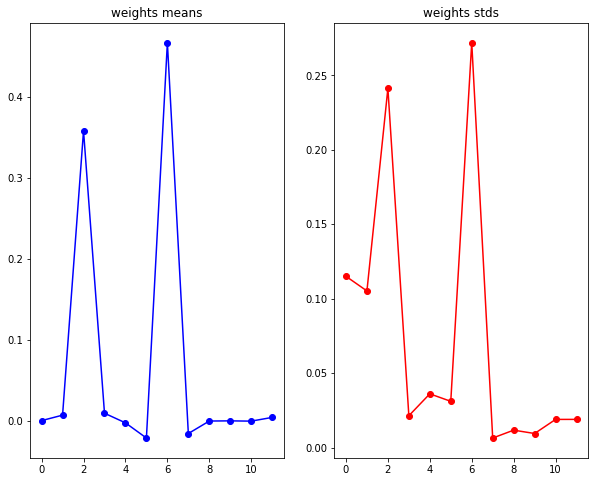

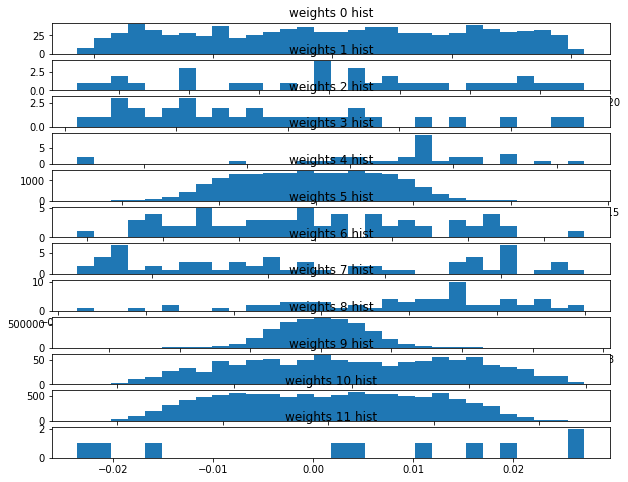

In [60]:
print(small_filter_model)
plot_mean_std_hist(small_filter_model.parameters())

## Tmp test

In [96]:
# check layer output size
test_layer = nn.Conv2d(3, 32, kernel_size=7, stride=1)
x = Variable(torch.randn(2, 3, 32, 32).type(torch.FloatTensor))
y = test_layer(x)
print(y.size())

torch.Size([2, 32, 26, 26])
